In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

# --- Paths
CWD = Path.cwd()
ROOT = CWD.parent if CWD.name.lower() == "notebooks" else CWD
RAW  = ROOT / "data" / "raw" / "assistant"
OUTT = ROOT / "reports" / "tables"
OUTT.mkdir(parents=True, exist_ok=True)

# --- Load inputs (X) and targets (y)
X = np.load(RAW / "Design_space2.npy", allow_pickle=False)            # (3010000, 3)
Mn_nom = np.load(RAW / "ACI440_Mn.npy", allow_pickle=False).ravel()   # (3010000,)
Mu2    = np.load(RAW / "Mu2.npy", allow_pickle=False).ravel()          # (3010000,)
AnaMu  = np.load(RAW / "Ana_TTC_M_u.npy", allow_pickle=False).ravel()  # (3010000,)

# --- Build tidy DataFrame (first 200k rows for fast profiling)
N = min(len(X), 200_000)
df = pd.DataFrame({
    "rho": X[:N, 0],
    "b":   X[:N, 1],
    "d":   X[:N, 2],
    "Mn_nom": Mn_nom[:N],
    "Mu2":    Mu2[:N],
    "AnaMu":  AnaMu[:N],
})

# --- Basic integrity & range checks
summary = df.describe(percentiles=[0.25,0.5,0.75]).T
nans = df.isna().sum()
negatives = (df < 0).sum()
zeros = (df == 0).sum()
dups = df.duplicated(subset=["rho","b","d"]).sum()

# --- Heuristic unit guesses (based on value ranges)
unit_guess = {
    "rho": "reinforcement ratio (dimensionless, likely 0.01–2.0 = 1–200%)",
    "b":   "mm (10–1000)",
    "d":   "mm (10–1000)",
    "Moments (Mn_nom/Mu2/AnaMu)": "kNm (typical 0–10,000)"
}

# --- Save a compact report
report_path = OUTT / "assistant_profile_summary.csv"
summary_out = summary.copy()
summary_out["n_nan"] = nans.reindex(summary_out.index).fillna(0).astype(int)
summary_out["n_zero"] = zeros.reindex(summary_out.index).fillna(0).astype(int)
summary_out["n_negative"] = negatives.reindex(summary_out.index).fillna(0).astype(int)
summary_out.to_csv(report_path)

print("Rows profiled:", len(df), "of", len(X))
print("Duplicate (rho,b,d) rows in sample:", dups)
print("Saved summary table to:", report_path)
print("\nHeuristic unit guesses:")
for k,v in unit_guess.items():
    print(f" - {k}: {v}")

summary_out


Rows profiled: 200000 of 3010000
Duplicate (rho,b,d) rows in sample: 0
Saved summary table to: C:\Users\amirn\thesis-rc-beam\reports\tables\assistant_profile_summary.csv

Heuristic unit guesses:
 - rho: reinforcement ratio (dimensionless, likely 0.01–2.0 = 1–200%)
 - b: mm (10–1000)
 - d: mm (10–1000)
 - Moments (Mn_nom/Mu2/AnaMu): kNm (typical 0–10,000)


,count,mean,std,min,25%,50%,75%,max,n_nan,n_zero,n_negative
rho,200000.0,0.073017,0.038250,0.010000,0.041508,0.073017,0.104525,0.136033,0,0,0
b,200000.0,505.000000,288.661422,10.000000,257.500000,505.000000,752.500000,1000.000000,0,0,0
d,200000.0,505.000000,288.661422,10.000000,257.500000,505.000000,752.500000,1000.000000,0,0,0
Mn_nom,200000.0,70.312127,87.842929,0.000084,7.580361,34.353024,100.471752,493.074934,0,0,0
Mu2,200000.0,109.849682,156.093802,0.000089,9.192766,44.441846,144.576859,1191.766904,0,0,0
AnaMu,200000.0,80.825930,103.036095,0.000089,8.354412,38.354601,113.846326,587.238816,0,0,0


In [2]:
import numpy as np, pandas as pd
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
RAW  = ROOT / "data" / "raw" / "assistant"

X     = np.load(RAW/"Design_space2.npy", allow_pickle=False)          # [rho(%), b(mm), d(mm)]
Mu2   = np.load(RAW/"Mu2.npy", allow_pickle=False).ravel()            # kNm-ish

# sample 20k points to keep it light
idx   = np.random.default_rng(42).choice(len(X), size=20_000, replace=False)
rho_p = X[idx,0]                    # percent
b_mm  = X[idx,1]
d_mm  = X[idx,2]
Mu2_s = Mu2[idx]

rho   = rho_p/100.0                 # fraction
As_mm2 = rho * b_mm * d_mm          # mm^2

fy   = 500.0    # MPa (N/mm^2), rough assumption
z_mm = 0.9*d_mm # lever arm ~0.9d, rough

# Nominal steel-controlled moment (simplified): Mn ≈ 0.87*fy*As*z  [N*mm] → /1e6 = kN*m
Mn_est_kNm = 0.87 * fy * As_mm2 * z_mm / 1e6

df = pd.DataFrame({
    "rho_%": rho_p, "b_mm": b_mm, "d_mm": d_mm,
    "Mu2_kNm": Mu2_s, "Mn_est_kNm": Mn_est_kNm
})

print(df[["Mu2_kNm","Mn_est_kNm"]].describe().T)
print("\nCorrelation (log-scale) between Mu2 and Mn_est:", 
      np.corrcoef(np.log10(Mu2_s+1e-6), np.log10(Mn_est_kNm+1e-6))[0,1])

# show a few rows to see orders of magnitude align
df.head(10)


              count         mean          std       min        25%  \
Mu2_kNm     20000.0  1102.103654  1500.333722  0.000804  86.702897   
Mn_est_kNm  20000.0   670.405265   994.025231  0.000352  46.534781   

                   50%          75%          max  
Mu2_kNm     448.869625  1534.415142  9471.447437  
Mn_est_kNm  244.472674   867.938793  7544.719170  

Correlation (log-scale) between Mu2 and Mn_est: 0.9965795199601749


,rho_%,b_mm,d_mm,Mu2_kNm,Mn_est_kNm
0,0.043167,200.0,790.0,47.753407,21.094268
1,0.593733,390.0,290.0,160.087519,76.240160
2,0.116133,480.0,680.0,226.270461,100.913140
3,0.155933,190.0,820.0,174.206804,77.992355
4,1.814267,360.0,810.0,2233.020110,1677.665703
5,0.354933,890.0,30.0,2.451655,1.113041
6,0.507500,410.0,50.0,4.450503,2.036534
7,1.383100,170.0,520.0,393.431354,248.909204
8,0.155933,470.0,590.0,223.092869,99.878638
9,1.754567,50.0,420.0,82.388145,60.585713


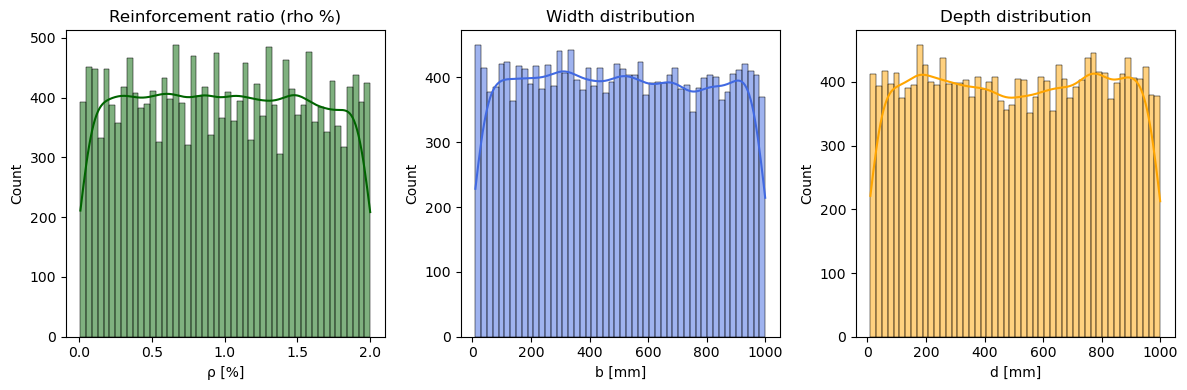

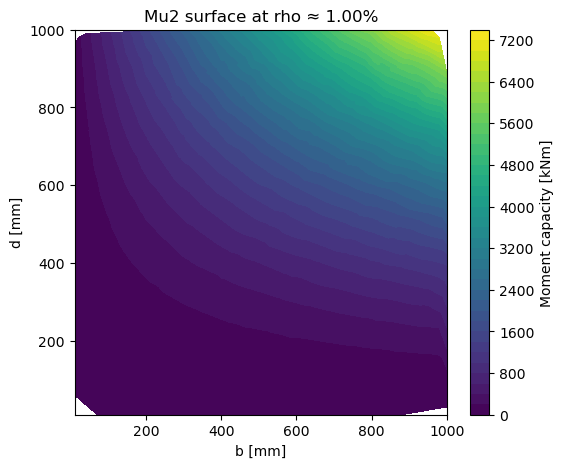

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use smaller subset for plotting
df_plot = df.sample(20000, random_state=0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.histplot(df_plot["rho_%"], bins=50, kde=True, color="darkgreen")
plt.title("Reinforcement ratio (rho %)")
plt.xlabel("ρ [%]")

plt.subplot(1,3,2)
sns.histplot(df_plot["b_mm"], bins=50, kde=True, color="royalblue")
plt.title("Width distribution")
plt.xlabel("b [mm]")

plt.subplot(1,3,3)
sns.histplot(df_plot["d_mm"], bins=50, kde=True, color="orange")
plt.title("Depth distribution")
plt.xlabel("d [mm]")
plt.tight_layout()
plt.show()

# 2D contour: Mu2 vs b and d at fixed rho
import numpy as np
rho_level = 1.0  # 1%
mask = (df_plot["rho_%"].between(rho_level-0.05, rho_level+0.05))
df_rho = df_plot[mask]
plt.figure(figsize=(6,5))
plt.tricontourf(df_rho["b_mm"], df_rho["d_mm"], df_rho["Mu2_kNm"], levels=40, cmap="viridis")
plt.colorbar(label="Moment capacity [kNm]")
plt.xlabel("b [mm]")
plt.ylabel("d [mm]")
plt.title(f"Mu2 surface at rho ≈ {rho_level:.2f}%")
plt.show()


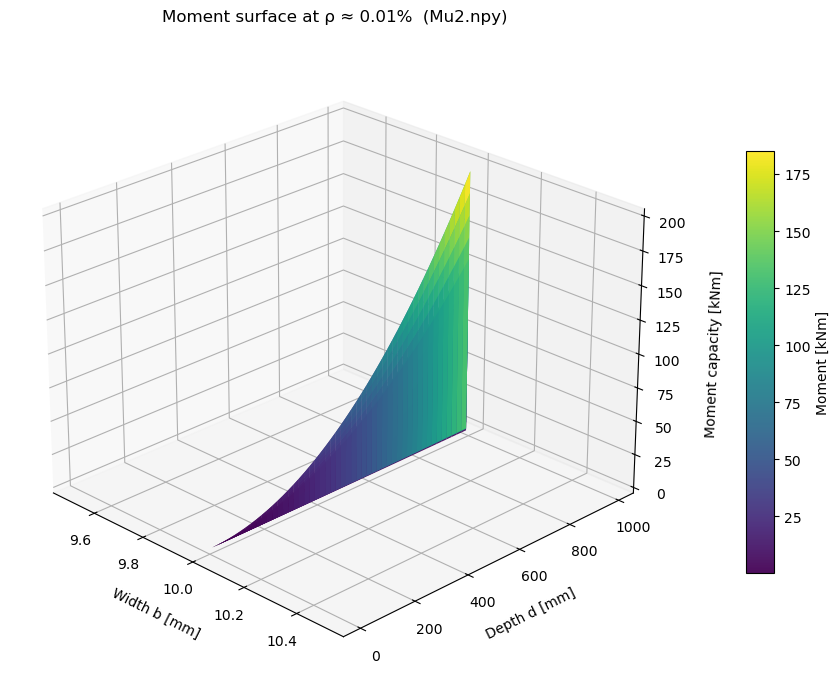

Saved figure to: C:\Users\amirn\thesis-rc-beam\reports\figures\mu_surface_rho_0.01pct_Mu2.png


In [10]:
# --- 3D Mu surface at a chosen rho (%)  (handles flat or 3-D moment arrays)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
RAW  = ROOT / "data" / "raw" / "assistant"
FIGS = ROOT / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

moment_file = "Mu2.npy"     # or "ACI440_Mn.npy" or "Ana_TTC_M_u.npy"
rho_target_percent = 1.00   # choose rho [%] to visualize

# Load meshes
mesh = np.load(RAW / "designspace_meshgrid_data.npz")
rho_mesh = mesh["rho_mesh"]            # (100, 301, 100) [%]
b_mesh   = mesh["b_mesh"]              # (100, 301, 100) [mm]
d_mesh   = mesh["d_mesh"]              # (100, 301, 100) [mm]
mesh_shape = rho_mesh.shape            # (100, 301, 100)

# Load moment array (could be 1-D or 3-D)
Mu_raw = np.load(RAW / moment_file, allow_pickle=False)

# If flattened, reshape to mesh shape
if Mu_raw.ndim == 1:
    if Mu_raw.size != np.prod(mesh_shape):
        raise ValueError(f"{moment_file} size {Mu_raw.size} does not match mesh size {np.prod(mesh_shape)}")
    Mu_grid = Mu_raw.reshape(mesh_shape, order="C")
else:
    Mu_grid = Mu_raw
    if Mu_grid.shape != mesh_shape:
        raise ValueError(f"{moment_file} shape {Mu_grid.shape} does not match mesh {mesh_shape}")

# Pick the closest rho slice
rho_vals = rho_mesh[:,0,0]                           # unique rho values along axis 0
i = int(np.argmin(np.abs(rho_vals - rho_target_percent)))
rho_selected = float(rho_vals[i])

# Extract surfaces at that rho
B  = b_mesh[i, :, :]          # (301, 100)
D  = d_mesh[i, :, :]          # (301, 100)
Mu = Mu_grid[i, :, :]         # (301, 100)  kNm

# Optional downsample for faster rendering
Bds, Dds, Muds = B[::2, ::2], D[::2, ::2], Mu[::2, ::2]

# 3D plot
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Bds, Dds, Muds, cmap='viridis', linewidth=0, antialiased=True, alpha=0.95)

ax.set_title(f"Moment surface at ρ ≈ {rho_selected:.2f}%  ({moment_file})", pad=12)
ax.set_xlabel("Width b [mm]", labelpad=8)
ax.set_ylabel("Depth d [mm]", labelpad=8)
ax.set_zlabel("Moment capacity [kNm]", labelpad=10)
fig.colorbar(surf, shrink=0.65, aspect=15, pad=0.1, label="Moment [kNm]")
ax.view_init(elev=25, azim=-45)

out_path = FIGS / f"mu_surface_rho_{rho_selected:.2f}pct_{moment_file.replace('.npy','')}.png"
plt.tight_layout(); plt.savefig(out_path, dpi=160); plt.show()
print("Saved figure to:", out_path)


Detected rho axis = 1 with range [0.01, 2]
Chosen rho levels (%): 0.10, 0.50, 1.00, 1.50, 2.00


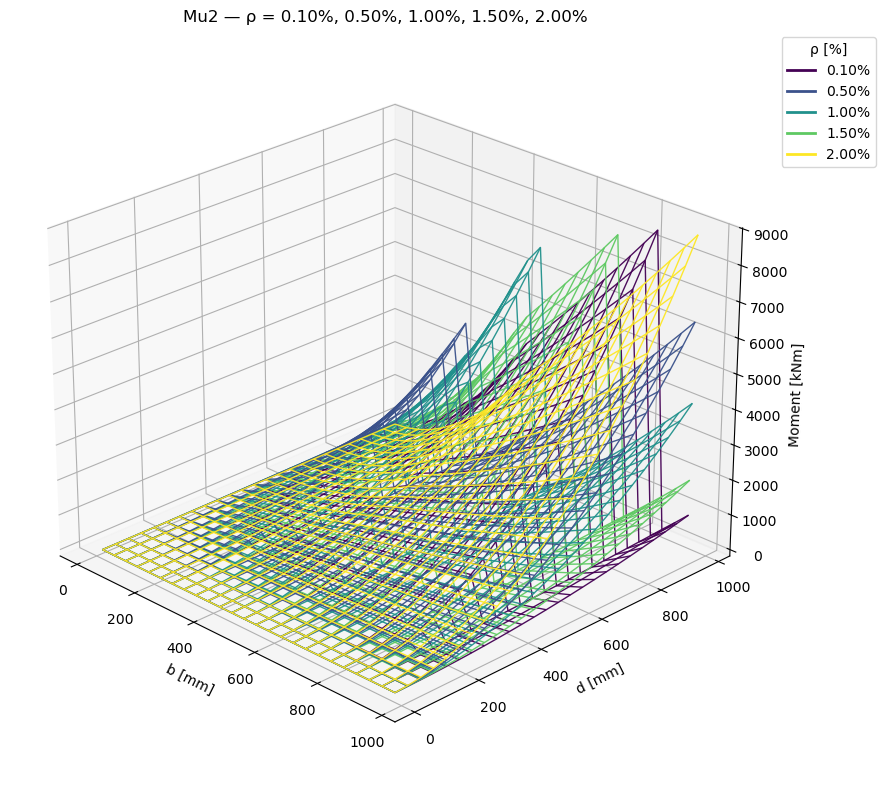

Saved: C:\Users\amirn\thesis-rc-beam\reports\figures\mu_wire_rho_5_Mu2.png


In [14]:
# Overlay 5 rho levels in one 3D plot (auto-detect rho axis) — NumPy 2.x compatible
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.lines import Line2D

# ---------------- CONFIG ----------------
moment_file = "Mu2.npy"               # "Mu2.npy" | "ACI440_Mn.npy" | "Ana_TTC_M_u.npy"
rho_targets_percent = [0.10, 0.50, 1.00, 1.50, 2.00]   # the five levels to overlay
stride_u, stride_v = 4, 4             # downsample for speed/clarity
# ----------------------------------------

ROOT = Path.cwd().parent if Path.cwd().name.lower()=="notebooks" else Path.cwd()
RAW  = ROOT / "data" / "raw" / "assistant"
FIGS = ROOT / "reports" / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

# Load meshes
mesh = np.load(RAW / "designspace_meshgrid_data.npz")
rho_mesh = mesh["rho_mesh"]       # shape (a,b,c)
b_mesh   = mesh["b_mesh"]
d_mesh   = mesh["d_mesh"]
shape3   = rho_mesh.shape

# Load moment; reshape if flat
Mu_raw = np.load(RAW / moment_file, allow_pickle=False)
Mu_grid = Mu_raw.reshape(shape3) if Mu_raw.ndim == 1 else Mu_raw
if Mu_grid.shape != shape3:
    raise ValueError(f"{moment_file} shape {Mu_grid.shape} != mesh {shape3}")

# ---- Detect which axis holds rho variation (use np.ptp)
def series_along_axis(arr3, axis):
    idx = [0, 0, 0]
    idx[axis] = slice(None)
    return np.asarray(arr3[tuple(idx)]).ravel()

ranges = [np.ptp(series_along_axis(rho_mesh, ax)) for ax in range(3)]
rho_axis_idx = int(np.argmax(ranges))

# Extract the 1D rho values along that axis (fix the other two at 0)
def rho_axis_values(arr3, axis):
    idx = [0, 0, 0]
    idx[axis] = slice(None)
    vals = np.asarray(arr3[tuple(idx)]).reshape(arr3.shape[axis])
    return vals

rho_axis_vals = rho_axis_values(rho_mesh, rho_axis_idx).astype(float)
rho_min, rho_max = float(np.nanmin(rho_axis_vals)), float(np.nanmax(rho_axis_vals))
print(f"Detected rho axis = {rho_axis_idx} with range [{rho_min:.4g}, {rho_max:.4g}]")

# ---- Units: some sets store ρ as 0.01..2.00 (meaning 0.01%..2.00%), others 1..200 (% directly)
if rho_max <= 2.5:
    to_axis = lambda p: p          # targets already in same 0..2 scale (percent-style)
else:
    to_axis = lambda p: p          # targets are % and axis is 0..200 %, same mapping

# Helper: slice 2D surface at a rho index
def slice_at_rho(i):
    sl = [slice(None)]*3
    sl[rho_axis_idx] = i
    return b_mesh[tuple(sl)], d_mesh[tuple(sl)], Mu_grid[tuple(sl)]

# Map target percents to nearest indices on detected axis
def nearest_index_for_percent(p):
    tgt = to_axis(p)
    return int(np.nanargmin(np.abs(rho_axis_vals - tgt)))

idxs = [nearest_index_for_percent(p) for p in rho_targets_percent]
chosen_rhos = [float(rho_axis_vals[i]) for i in idxs]
print("Chosen rho levels (%):", ", ".join(f"{r:.2f}" for r in chosen_rhos))

# ---- Plot 5 wireframes in one 3D figure
fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap("viridis")
legend_lines = []

for k, (p, i) in enumerate(zip(rho_targets_percent, idxs)):
    B, D, Mu = slice_at_rho(i)
    B, D, Mu = B[::stride_u, ::stride_v], D[::stride_u, ::stride_v], Mu[::stride_u, ::stride_v]
    color = cmap(k/(len(idxs)-1) if len(idxs) > 1 else 0.5)
    ax.plot_wireframe(B, D, Mu, rstride=1, cstride=1, color=color, linewidth=1.0, alpha=0.95)
    legend_lines.append(Line2D([0],[0], color=color, lw=2, label=f"{p:.2f}%"))

ax.set_title(f"{moment_file.replace('.npy','')} — ρ = " + ", ".join(f"{p:.2f}%" for p in rho_targets_percent))
ax.set_xlabel("b [mm]"); ax.set_ylabel("d [mm]"); ax.set_zlabel("Moment [kNm]")
ax.view_init(elev=25, azim=-45)
ax.legend(handles=legend_lines, bbox_to_anchor=(1.02, 1), loc="upper left", title="ρ [%]")
plt.tight_layout()

out = FIGS / f"mu_wire_rho_5_{moment_file.replace('.npy','')}.png"
plt.savefig(out, dpi=160); plt.show()
print("Saved:", out)
